In [135]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np

import torch
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt

%matplotlib inline

from controllers import DeePC, DDeePC
plt.rcParams["figure.figsize"] = (15,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')

In [137]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix
n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                           

In [138]:
ud[:Tini,:]

array([[ 0.14642833, -1.94553436, -0.58526344],
       [-0.93401882, -0.30946099, -0.89991238],
       [-0.82156808, -0.06579069, -1.12469463],
       [-1.32173072,  1.11174569, -0.03655052]])

In [139]:
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([10,10,10]))
u_constraonts = np.kron(np.ones(Tf), np.array([2,2,2]))

In [51]:
A = torch.Tensor([4,9,25])
torch.sqrt(A)

tensor([2., 3., 5.])

In [142]:
q = torch.ones(3)*10
r = torch.ones(3)*0.1

controller = DDeePC(
    ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3,
    y_constraints=y_constraints, u_constraints=u_constraonts,
    stochastic=False, linear=True, q=q, r=r
)

for param in controller.parameters():
    print(param)

ref = np.ones(Tf*3)*2
input, output = controller(ref=torch.Tensor(ref), u_ini=torch.Tensor(u_ini), y_ini=torch.Tensor(y_ini))


ud shape : (67, 3), yd shape : (67, 3)


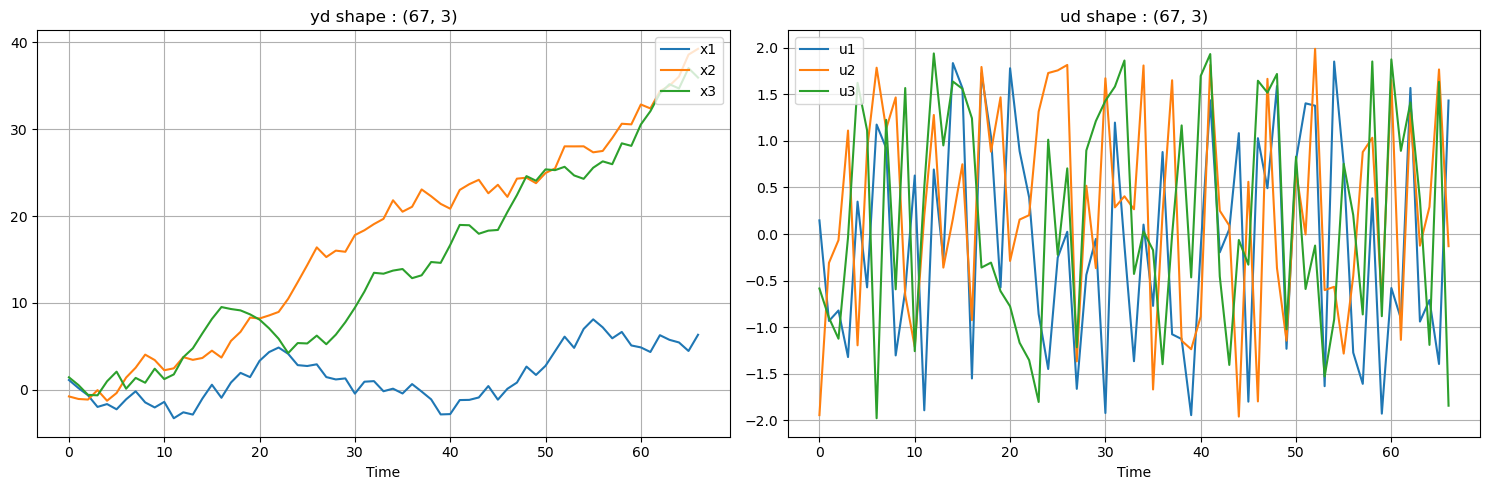

In [143]:
print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid(True)
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

In [4]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([10,10,10]))
u_constraonts = np.kron(np.ones(Tf), np.array([2,2,2]))
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m
)

In [5]:
def imitation_loss(ref : np.array, q_est : torch.Tensor, r_est : torch.Tensor) -> torch.Tensor:

    # Expert
    controller.setup(ref=ref, Q=Q, R=R, u_ini=u_ini, y_ini=y_ini)
    _, expert_g = controller.solve(verbose=False, solver=cp.ECOS)

    # Learner
    Q_est = np.diag(q_est.detach().numpy())
    R_est = np.diag(r_est.detach().numpy())
    controller.setup(ref=ref, Q=Q_est, R=R_est, u_ini=u_ini, y_ini=y_ini)
    _, learner_g = controller.solve(verbose=False, solver=cp.ECOS)

    # Construct loss
    expert_g, learner_g = torch.Tensor(expert_g), torch.Tensor(learner_g)
    loss = torch.mean((expert_g - learner_g)**2)
    loss.requires_grad_(True)
    return loss


In [6]:
weight_est, ctrl_est = Parameter(torch.randn(size=(3,))*0.1+1), Parameter(torch.randn(size=(3,))*0.1+1)
print(f'Q = {weight_est}\nR = {ctrl_est}')

Q = Parameter containing:
tensor([1.1468, 0.9913, 1.0558], requires_grad=True)
R = Parameter containing:
tensor([0.9748, 0.9709, 1.1483], requires_grad=True)


In [7]:
opt = optim.RMSprop((weight_est, ctrl_est), lr=1e-2)
pbar = tqdm(range(1000), ncols=120)

for i in pbar:
    ref = np.random.uniform(low=-2, high=2, size=(m,)) # Random reference 
    ref = np.kron(np.ones(controller.N), ref)

    loss = imitation_loss(ref, weight_est, ctrl_est)
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Used to checj the difference in ratio of ctrl cost and state cost
    model_loss = np.abs(100 - weight_est.sum().item() / ctrl_est.sum().item())

    pbar.set_description(f'Loss = {loss.item():.10f}, Model Loss = {model_loss:.2f}, ref = {ref[0]:.2f},{ref[1]:.2f},{ref[2]:.2f}')


Loss = 0.0089376466, Model Loss = 98.97, ref = 1.67,1.94,-1.12:  20%|███▏            | 200/1000 [00:10<00:41, 19.20it/s]


ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

In [ ]:
loss

tensor(0.0275, requires_grad=True)

In [ ]:
print(f'Q = {weight_est}\nR = {ctrl_est}')

Q = Parameter containing:
tensor([1.0490, 1.0408, 1.0696], requires_grad=True)
R = Parameter containing:
tensor([1.0583, 1.1592, 1.1008], requires_grad=True)


In [10]:
from cvxpylayers.torch import CvxpyLayer

n, m = 2, 3
x = cp.Variable(n)
A = cp.Parameter((m, n))
b = cp.Parameter(m)
constraints = [x >= 0]
objective = cp.Minimize(0.5 * cp.pnorm(A @ x - b, p=1))
problem = cp.Problem(objective, constraints)
assert problem.is_dpp()

cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables=[x])
A_tch = Parameter(torch.randn(m, n, requires_grad=True))
b_tch = Parameter(torch.randn(m, requires_grad=True))

# solve the problem
solution = cvxpylayer(A_tch, b_tch)
out = solution[0]
# compute the gradient of the sum of the solution with respect to A, b
# b = b.sum()
print(b_tch.grad)

tensor([ 0.0004, -0.0004], grad_fn=<_CvxpyLayerFnFnBackward>)
None
